[ Source : https://www.youtube.com/watch?v=_BdBJOOqMes&list=PLtGXgNsNHqPTgP9wyR8pmy2EuM2ZGHU5Z&index=1 ]

#### PREPARATION

In [1]:
# Connect to drive to retrieve data 
# (you might need to copy the DATA folder onto your Google Drive manually)
from google.colab import drive
drive.mount('/content/drive');

Mounted at /content/drive


In [2]:
# (Installation)
!pip install mne;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 40.4 MB/s eta 0:00:00


In [3]:
# Imports
from glob import glob

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os, mne

In [4]:
# Activate GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [5]:
# Navigate to project directory 
%cd drive/MyDrive/Github/IANNWTF_hw/Final
%ls

/content/drive/MyDrive/Github/IANNWTF_hw/Final
DATA/  EEGNet.ipynb


### DATA 

Data Summary:

This dataset contains electroencephalographic (EEG) recordings of 25 healthy participants who tested the Brain Invaders, a visual P300 Brain-Computer Interface inspired by the classic video game Space Invaders. The visual P300 is an event-related potential elicited by a visual stimulation, peaking 240-600 ms after stimulus onset. The EEG data were recorded using 16 electrodes in an experiment conducted at the GIPSA-lab in Grenoble, France in 2012 (Van Veen, 2013 and Congedo, 2013). The experiment description is available at [https://hal.archives-ouvertes.fr/hal-02126068 ]. Python code for manipulating the data is available at [https://github.com/plcrodrigues/py.BI.EEG.2012-GIPSA ]. The ID of this dataset is BI.EEG.2012-GIPSA.

The BCI Competition IV dataset 2a is a publicly available dataset of EEG recordings from healthy participants. EEG is a non-invasive method of measuring the electrical activity of the brain.

#### Load all data samples from Google Drive

In [251]:
%ls 
all_file_path = glob('DATA/**/**/*.csv', recursive=True)
print(len(all_file_path), all_file_path[0])
training_file_path = [p for p in all_file_path if "training.csv" in p.split("/")]
print(len(training_file_path), training_file_path[0])
online_file_path = [p for p in all_file_path if "online.csv" in p.split("/")]
print(len(online_file_path), online_file_path[0])

DATA/  EEGNet.ipynb
24 DATA/subject_04/subject_04/online.csv
12 DATA/subject_04/subject_04/training.csv
12 DATA/subject_04/subject_04/online.csv


In [252]:
# Parameters for reading EEG data
chnames = ['F7',
          'F3',
          'Fz',
          'F4',
          'F8',
          'T7',
          'C3',
          'Cz',
          'C4',
          'T8',
          'P7',
          'P3',
          'Pz',
          'P4',
          'P8',
          'O1',
          'O2',
          'STI 014']
chtypes = ['eeg'] * 17 + ['stim']  
info = mne.create_info(ch_names=chnames, sfreq=128,
                      ch_types=chtypes,
                      verbose=False)
info.set_montage(montage='standard_1020')

# Parameters for preprocessing
fmin = 1
fmax = 24

In [253]:
def read_data(file_path, info, fmin, fmax):
  raw_list = []
  epoch_list = []
  for path in file_path:
    # Reads original data
    print("Reads in : ", path)
    data = pd.read_csv(path).T
    print("-> original shape :", data.shape)

    # Selects columns (???)
    S = data.iloc[1:18,:]
    stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
    data = np.concatenate([S, stim])
    print("-> modified shape :", data.shape, '\n')

    # Creates mne.io.Raw object
    data = mne.io.RawArray(data, info, verbose=False)   # preload : data will be loaded into memory at object creation for fast access during training
    # ?
    data.set_eeg_reference()
    # ?
    data.filter(fmin, fmax)
    
    # ???
    events = mne.find_events(raw=data.copy(), shortest_event=1, verbose=False)
    event_id = {'NonTarget': 1, 'Target': 2}
    epochs = mne.Epochs(data, events, event_id, tmin=0.0, tmax=0.8, baseline=None, verbose=False, preload=True)
    epochs.pick_types(eeg=True)
    print("-> epochs data set shape :", epochs[0].get_data().shape)
  
    raw_list.append(data)
    epoch_list.append(epochs)
    print("-----------------------------------------------")
  return raw_list, epoch_list

raw_list, epoch_list = read_data([training_file_path[0]], info, fmin, fmax);

Reads in :  DATA/subject_04/subject_04/training.csv
-> original shape : (20, 46995)
-> modified shape : (18, 46995) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-253-85b7dacad4d0>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------


#### Data Inspection

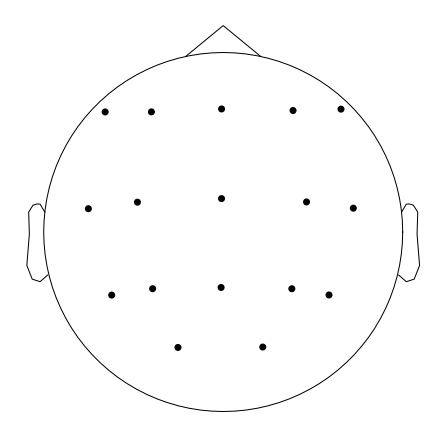

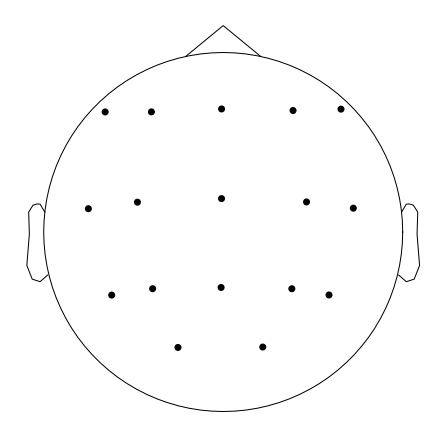

In [254]:
subj = 0

%matplotlib inline
# raw_list[0].plot_sensors(show=True)
# epoch_list[subj].info.set_montage('standard_1020')
epoch_list[subj].plot_sensors(show=True) # kind=topomap / 3d / select

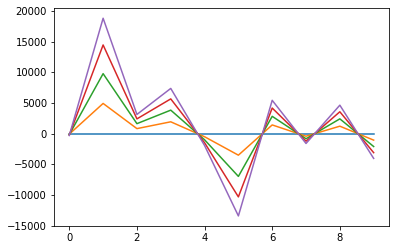

In [255]:
raw_list[subj].get_data().shape
plt.plot(raw_list[subj].get_data()[:10,:5]);

In [256]:
print(raw_list[subj])
raw_list[subj]

<RawArray | 18 x 46995 (367.1 s), ~6.5 MB, data loaded>


<RawArray | 18 x 46995 (367.1 s), ~6.5 MB, data loaded>

In [257]:
print(epoch_list[subj])
epoch_list[subj]

<Epochs |  765 events (all good), 0 - 0.796875 sec, baseline off, ~10.2 MB, data loaded,
 'NonTarget': 637
 'Target': 128>


Number of events,765
Events,NonTarget: 637Target: 128
Time range,0.000 – 0.797 sec
Baseline,off


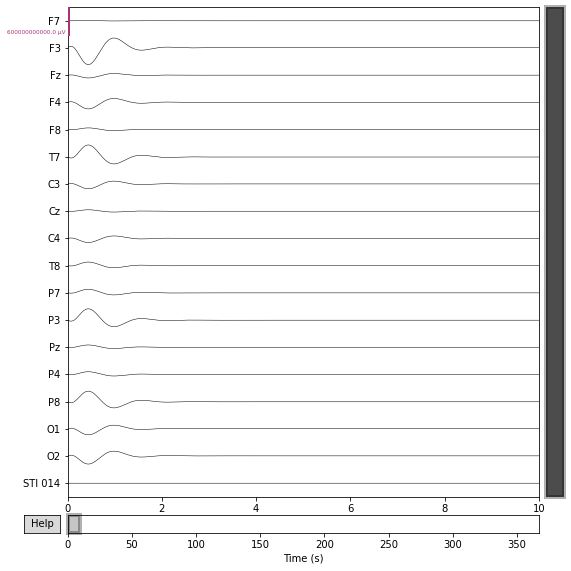

In [260]:
raw_list[subj].copy().plot(scalings=3e5); # Need to rescale from uV to V by 1e6, but thats weird... [Source : https://github.com/mne-tools/mne-python/issues/5539]

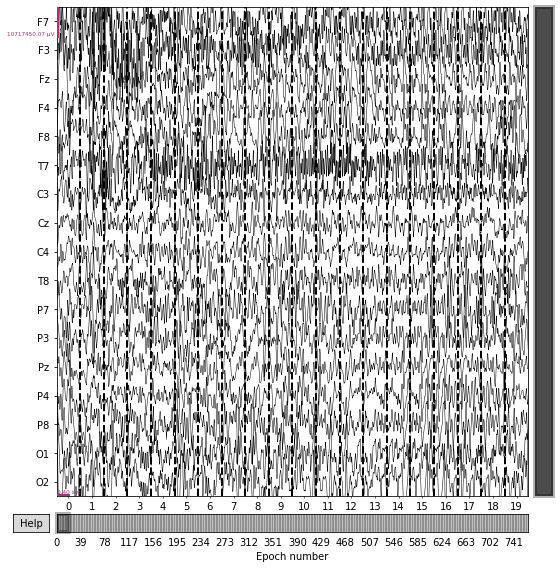

In [261]:
epoch_list[subj].copy().plot(scalings='auto');

Raw data and Training Epochs subject 0 || <class 'numpy.ndarray'>
----------------------------------------------------------------
[1] whole signal, channel  0 : (46995,)  || 3 % 
[2] one epoch, all channels  : (17, 103) || 20 % 
[3] one epoch, channel  0    : (103,)    || 20 %


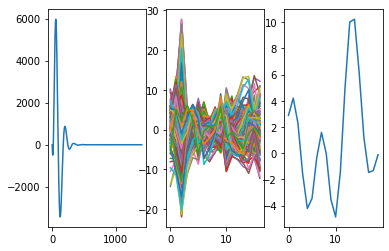

In [262]:
# Plotting interactively in more detail
chn = 0
e = 0
window_raw = 3
window_e = 20
window_e = 20

raw_data_matrix = raw_list[subj].get_data()[chn]
epochs_data_matrix = epoch_list[e].get_data()[chn]                                                 # <--- epoch_data_matrix = epochs.get_data()
print("Raw data and Training Epochs subject", subj, "||", type(raw_data_matrix))
print("----------------------------------------------------------------")

print("[1] whole signal, channel ",chn,":",raw_data_matrix.shape," ||",window_raw,"%", 
      "\n[2] one epoch, all channels  :",epochs_data_matrix.shape,"||",window_e,"%", 
      "\n[3] one epoch, channel ",chn,"   :",epochs_data_matrix[chn, :].shape,"   ||",window_e,"%")

epochs_chn_1 = epochs_data_matrix[chn,:]  # Select specific channel

plt.subplot(1, 3, 1)
# Plots the first 1% of the (above indexed) EEG signal's channel
plt.plot(raw_data_matrix[:int(raw_data_matrix.shape[0]/100*window_raw)])  ###/epochs_data_matrix.shape[1]
plt.subplot(1, 3, 2)
plt.plot(epochs_data_matrix[:int(epochs_data_matrix.shape[1]/100*window_e)])
plt.subplot(1, 3, 3)
plt.plot(epochs_chn_1[:int(epochs_data_matrix.shape[1]/100*window_e)])

plt.show()

[1] The amplitude of the EEG signal over time for the first channel.</br>
[2] The x-axis of the plot represents time, and the y-axis represents the amplitude of the EEG signal in microvolts. The shaded region around each line represents the standard error of the mean across epochs.</br>
[3] Similar to *\[2]* but only one channel selected

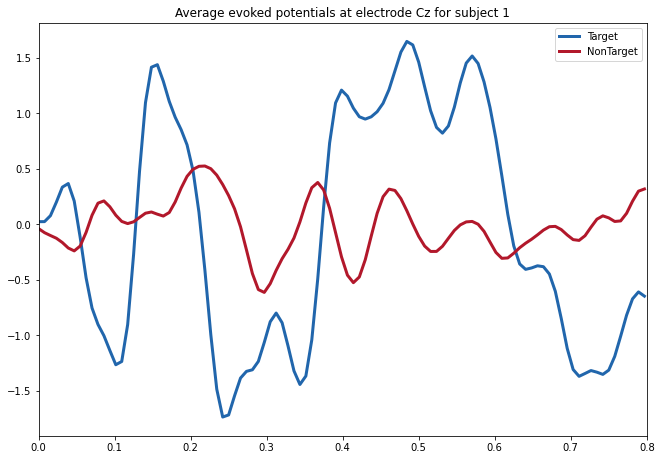

In [263]:
### from dataset paper...
raw_list[subj] 
chname2idx = {}
for i, chn in enumerate(raw_list[subj].ch_names):
  chname2idx[chn] = i

fig, ax = plt.subplots(facecolor='white', figsize=(10.9,  7.6))
evkTarget = epoch_list[subj]['Target'].average().data[chname2idx['Cz'],:]
evkNonTarget = epoch_list[subj]['NonTarget'].average().data[chname2idx['Cz'],:]
t = np.arange(len(evkTarget)) / epoch_list[subj].info['sfreq']
ax.plot(t, evkTarget, c='#2166ac', lw=3.0, label='Target')
ax.plot(t, evkNonTarget, c='#b2182b', lw=3.0, label='NonTarget')
ax.set_xlim(0, 0.8)
ax.set_title('Average evoked potentials at electrode Cz for subject ' + str(1))
ax.legend();

#### ICA

In [264]:
ica = mne.preprocessing.ICA(n_components=17, random_state=0)

In [265]:
ica.fit(raw_list[subj].copy().filter(1,24))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)

Fitting ICA to data using 17 channels (please be patient, this may take a while)
Selecting by number: 17 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished


Fitting ICA took 3.0s.


<ipython-input-265-dce87a27b40d>:1: RuntimeWarning: Using n_components=17 (resulting in n_components_=17) may lead to an unstable mixing matrix estimation because the ratio between the largest (17) and smallest (1e-30) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 1
  ica.fit(raw_list[subj].copy().filter(1,24))


Method,fastica
Fit,40 iterations on raw data (46995 samples)
ICA components,17
Available PCA components,17
Channel types,eeg
ICA components marked for exclusion,—


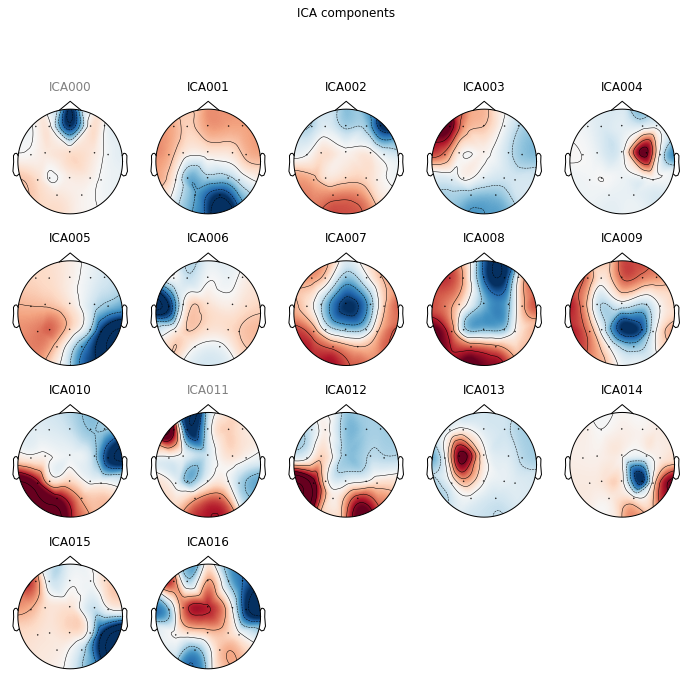

[<MNEFigure size 702x696.24 with 17 Axes>]

In [272]:
ica.plot_components()

In [271]:
ica.exclude = [0,11]

In [268]:
print(chnames)

['F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'STI 014']


In [273]:
bad_idx, scores = ica.find_bads_eog(raw_list[subj],chnames[16],threshold=2)
print(bad_idx)

Using EOG channel: O2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
-

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 2 ICA components
    Projecting back using 17 PCA components


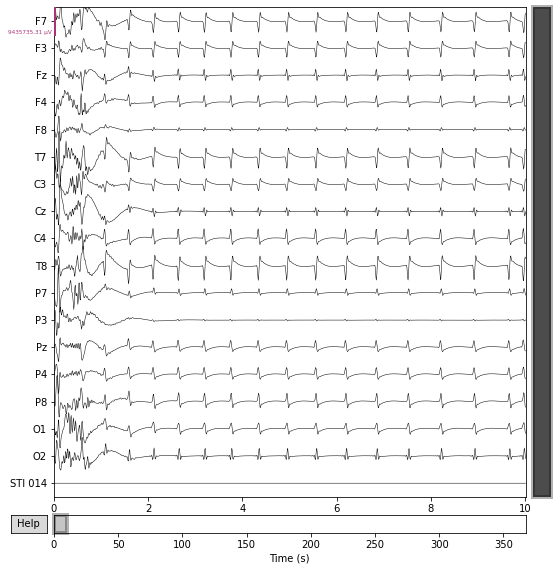

Applying ICA to Epochs instance
    Transforming to ICA space (17 components)
    Zeroing out 2 ICA components
    Projecting back using 17 PCA components


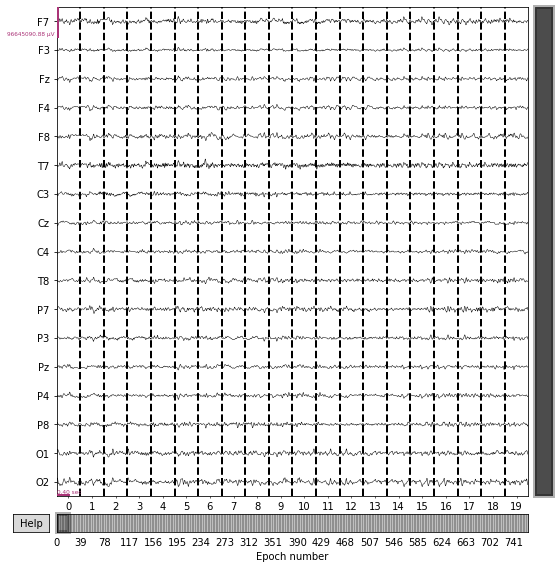

In [275]:
ica.apply(raw_list[subj].copy(), exclude=ica.exclude).plot(scalings='auto')
ica.apply(epoch_list[subj].copy(), exclude=ica.exclude).plot(scalings='auto');

#### next...